# ANN to predict ETF value

The ANN should learn from various titles based on many features

In [3]:
import yfinance as yf

data = []  # Lista per salvare i dati
# Lista dei ticker degli ETF più importanti
etf_tickers = ["SPY", "QQQ", "VTI", "EEM", "EFA"]

# Periodo di dati storici da scaricare (es. ultimi 10 anni)
period = "10y"

# Itera sui ticker e scarica i dati
for ticker in etf_tickers:
    etf = yf.Ticker(ticker)
    data.append(etf.history(period=period))  # Scarica dati storici
    data[-1].to_csv(f"{ticker}.csv")  # Salva in un file CSV
    print(f"Dati di {ticker} salvati con successo!")

print("Download completato.")


Dati di SPY salvati con successo!
Dati di QQQ salvati con successo!
Dati di VTI salvati con successo!
Dati di EEM salvati con successo!
Dati di EFA salvati con successo!
Download completato.


# FEATURE ENGINEERING

new features added = ['Pct_Change', 'MA_10', 'MA_50', 'Volatility_10', 'Volume_Norm', 'RSI_14']

In [4]:
# FEATURE ENGINEERING

features = ['Pct_Change', 'MA_10', 'MA_50', 'Volatility_10', 'Volume_Norm', 'RSI_14']

# Funzione per calcolare l'RSI
def compute_rsi(series, window=14):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# Aggiungi variazione percentuale del prezzo

for i in range(len(data)):

    data[i]['Pct_Change'] = data[i]['Close'].pct_change() * 100  # Variazione percentuale giornaliera

    # Aggiungi la media mobile a 10 e 50 giorni
    data[i]['MA_10'] = data[i]['Close'].rolling(window=10).mean()
    data[i]['MA_50'] = data[i]['Close'].rolling(window=50).mean()

    # Aggiungi la volatilità (deviazione standard su 10 giorni)
    data[i]['Volatility_10'] = data[i]['Close'].rolling(window=10).std()

    # Normalizza il volume per evitare valori troppo grandi
    data[i]['Volume_Norm'] = data[i]['Volume'] / data[i]['Volume'].rolling(window=10).mean()
    
    # Aggiungi RSI con finestra di 14 giorni
    data[i]['RSI_14'] = compute_rsi(data[i]['Close'])

    # Rimuove i valori NaN dovuti al rolling
    data[i] = data[i].dropna()

    # Verifica le nuove colonne
    print(data[i].head())

                                 Open        High         Low       Close  \
Date                                                                        
2015-04-20 00:00:00-04:00  176.426677  177.430925  176.342294  177.093369   
2015-04-21 00:00:00-04:00  177.785387  177.945731  176.578610  176.882416   
2015-04-22 00:00:00-04:00  177.228403  177.937293  176.291668  177.751633   
2015-04-23 00:00:00-04:00  177.346501  178.857097  177.228355  178.198853   
2015-04-24 00:00:00-04:00  178.620828  178.882437  178.156678  178.612381   

                              Volume  Dividends  Stock Splits  Capital Gains  \
Date                                                                           
2015-04-20 00:00:00-04:00   92189500        0.0           0.0            0.0   
2015-04-21 00:00:00-04:00   72559800        0.0           0.0            0.0   
2015-04-22 00:00:00-04:00   78264600        0.0           0.0            0.0   
2015-04-23 00:00:00-04:00  102585900        0.0           0.

## To verify what to keep and what to trash

In [5]:
split_ratio_train = 0.8
split_ratio_valid = 0.9  # 80% train, 10% valid, 10% test

train_data = []
valid_data = []
test_data = []

for i in range(len(data)):
    dataset = data[i]  # Prendi il dataset dell'ETF i-esimo
    split_idx1 = int(len(dataset) * split_ratio_train)
    split_idx2 = int(len(dataset) * split_ratio_valid)
    
    train_data.append(dataset.iloc[:split_idx1])   # Dati di training (80%)
    valid_data.append(dataset.iloc[split_idx1:split_idx2])  # Dati di validazione (10%)
    test_data.append(dataset.iloc[split_idx2:])   # Dati di test (10%)

    print(f"Dataset {i}: Train {len(train_data[i])}, Valid {len(valid_data[i])}, Test {len(test_data[i])}")


Dataset 0: Train 1972, Valid 247, Test 247
Dataset 1: Train 1972, Valid 247, Test 247
Dataset 2: Train 1972, Valid 247, Test 247
Dataset 3: Train 1972, Valid 247, Test 247
Dataset 4: Train 1972, Valid 247, Test 247


# Da rifare a partire da qui, data non deve contenere solo la variazione percentuale

In [8]:
import numpy as np

# Configurazione della finestra temporale
window = 50

# Funzione per creare sequenze temporali
def create_sequences(data_list, window):
    x, y = [], []
    data = []
    for dataset in data_list:  # Itera su ogni ETF
        for feature in features:
            data.append(dataset[feature].values)

        for i in range(len(data) - window):
            x.append(data[0][i:i+window])   # Finestra temporale di dimensione `window`
            y.append(data[0][i+window])     # Prossima variazione percentuale
            x.append(data[1][i:i+window])   # Finestra temporale di dimensione `window`
            y.append(data[1][i+window])     # Prossima variazione percentuale
            x.append(data[2][i:i+window])   # Finestra temporale di dimensione `window`
            y.append(data[2][i+window])     # Prossima variazione percentuale
            x.append(data[3][i:i+window])   # Finestra temporale di dimensione `window`
            y.append(data[3][i+window])     # Prossima variazione percentuale
            x.append(data[4][i:i+window])   # Finestra temporale di dimensione `window`
            y.append(data[4][i+window])     # Prossima variazione percentuale

    return np.array(x), np.array(y)

# Crea le sequenze temporali per ogni set
x_train, y_train = create_sequences(train_data, window)
x_valid, y_valid = create_sequences(valid_data, window)
x_test, y_test = create_sequences(test_data, window)

num_features = len(features)  # Se hai 5 variabili (Open, High, Low, Close, Volume) sarà 5

# Reshape per adattare alla LSTM (aggiunge la dimensione delle features)
x_train = x_train.reshape((x_train.shape[0], window, num_features))
x_valid = x_valid.reshape((x_valid.shape[0], window, num_features))
x_test = x_test.reshape((x_test.shape[0], window, num_features))

# Anche y_train, y_valid e y_test devono essere 2D per l'output del modello
y_train = y_train.reshape((-1, 1))
y_valid = y_valid.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

# Stampa delle forme dei set
print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}")
print(f"x_valid shape: {x_valid.shape}, y_valid shape: {y_valid.shape}")
print(f"x_test shape: {x_test.shape}, y_test shape: {y_test.shape}")


x_train shape: (0,), y_train shape: (0,)
x_valid shape: (0,), y_valid shape: (0,)
x_test shape: (0,), y_test shape: (0,)


In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization

# Creazione del modello LSTM migliorato
model = Sequential()

# Primo strato LSTM
model.add(LSTM(units=64, return_sequences=True, input_shape=(window, num_features)))
model.add(BatchNormalization())  # Normalizza l'attivazione dei layer
model.add(Dropout(0.1))

# Secondo strato LSTM
model.add(LSTM(units=64, return_sequences=True))
model.add(BatchNormalization())
model.add(Dropout(0.1))

# Terzo strato LSTM (senza return_sequences)
model.add(LSTM(units=64, return_sequences=False))
model.add(BatchNormalization())
model.add(Dropout(0.1))

# Strato Fully Connected per migliorare la modellazione non lineare
model.add(Dense(units=32, activation="relu")) 
model.add(Dense(units=1))  # Output: variazione percentuale predetta

# Compilazione del modello
model.compile(optimizer='adam', loss='mse')

# Training
hist = model.fit(x_train, y_train, epochs=50, batch_size=32, validation_data=(x_valid, y_valid))


c:\Users\sfori\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
301/301 ━━━━━━━━━━━━━━━━━━━━ 16s 39ms/step - loss: 1.9790 - val_loss: 0.7317
Epoch 2/50
301/301 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - loss: 1.7338 - val_loss: 0.7548
Epoch 3/50
301/301 ━━━━━━━━━━━━━━━━━━━━ 12s 40ms/step - loss: 1.7294 - val_loss: 0.8109
Epoch 4/50
301/301 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - loss: 1.7048 - val_loss: 0.7552
Epoch 5/50
301/301 ━━━━━━━━━━━━━━━━━━━━ 12s 40ms/step - loss: 1.6235 - val_loss: 0.7399
Epoch 6/50
301/301 ━━━━━━━━━━━━━━━━━━━━ 13s 42ms/step - loss: 1.6046 - val_loss: 0.7739
Epoch 7/50
301/301 ━━━━━━━━━━━━━━━━━━━━ 13s 42ms/step - loss: 1.4954 - val_loss: 0.7656
Epoch 8/50
301/301 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - loss: 1.6612 - val_loss: 0.7876
Epoch 9/50
301/301 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - loss: 1.4507 - val_loss: 0.7470
Epoch 10/50
301/301 ━━━━━━━━━━━━━━━━━━━━ 13s 42ms/step - loss: 1.5151 - val_loss: 0.7549
Epoch 11/50
301/301 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - loss: 1.4181 - val_loss: 0.7533
Epoch 12/50
301/301 ━━━━━━━━━━

KeyboardInterrupt: 

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5943
0.6866422891616821


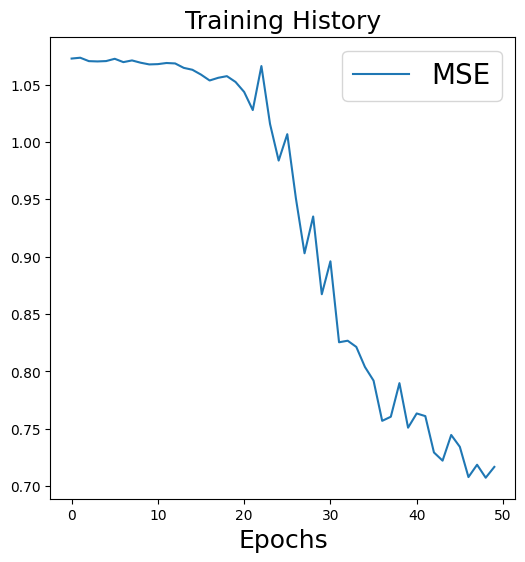

In [9]:
import matplotlib.pyplot as plt
# plot training epochs

fig, axes = plt.subplots(figsize=(6,6))

axes.plot(hist.history['loss'], label='MSE')

axes.set_title("Training History", fontsize=18)
axes.set_xlabel("Epochs", fontsize=18)
axes.legend(fontsize=20)

# Final accuracy
print ( model.evaluate(x_train, y_train))

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
2514
2020


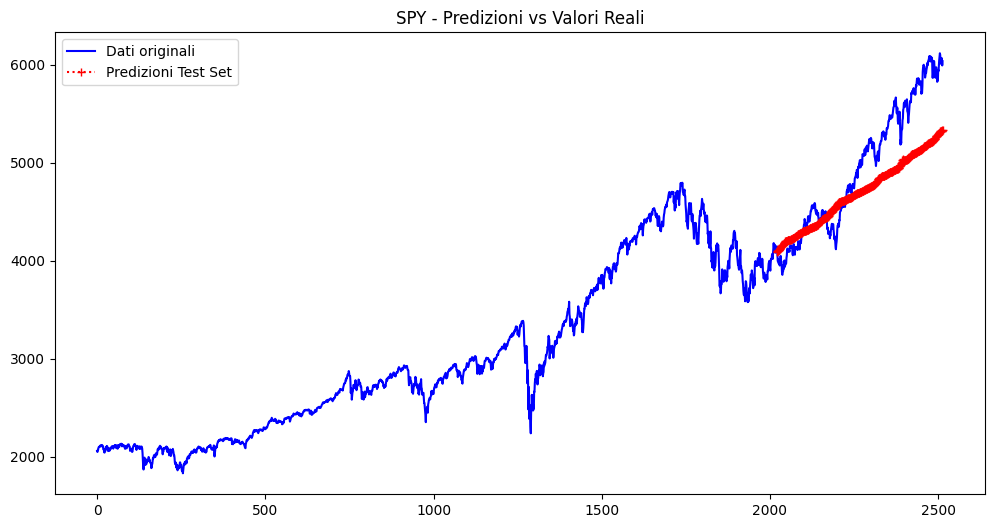

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Predizione
y_pred = model.predict(x_test)

# Ricostruzione del prezzo predetto
predicted_prices = []
last_known_price = data['Close'].iloc[-len(y_test)]  # Ultimo prezzo reale prima del test

predicted_prices.append(last_known_price)

for pct_change in y_pred.flatten():  # Assicuriamoci che sia un array 1D
    new_price = predicted_prices[-1] * (1 + pct_change / 100)
    predicted_prices.append(new_price)

predicted_prices = predicted_prices[1:]  # Rimuoviamo il primo valore iniziale

# Creazione del grafico
fig, ax = plt.subplots(figsize=(12, 6))

# Tutti i dati originali
ax.plot(range(len(data)), data['Close'], label="Dati originali", color='blue')

# Separazione fra train, valid e test
split_train = len(train_data)
split_valid = len(train_data) + len(valid_data)
split_test = split_valid + window

# Linea verticale per separare le sezioni
ax.axvline(x=split_train, color='green', linestyle='--', label="Fine Train Set")
ax.axvline(x=split_valid, color='orange', linestyle='--', label="Fine Validation Set")

# Predizioni (Test set)
ax.plot(range(split_test, split_test + len(predicted_prices)), 
        predicted_prices, 'r+-', label="Predizioni Test Set")

# Titolo e legenda
ax.set_title('ETF - Predizioni vs Valori Reali')
ax.legend()
plt.show()


Fare predizione su giorni futuri:
Dare in pasto a rete neurale valori di {window} giorni prima e l'output è il valore del window +1 giorno

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
[0.48702574]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
[0.48581266]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
[0.4845482]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
[0.4833181]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
[0.48211992]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
[0.48088533]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
[0.47967184]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
[0.47847176]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
[0.47730982]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
[0.47616303]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
[0.4749965]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
[0.47383446]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
[0.47268248]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
[0.47153848]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
[0.4704017]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
[0.46927148]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
[0.4681474]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
[0.4670292]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
[0.46591693]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

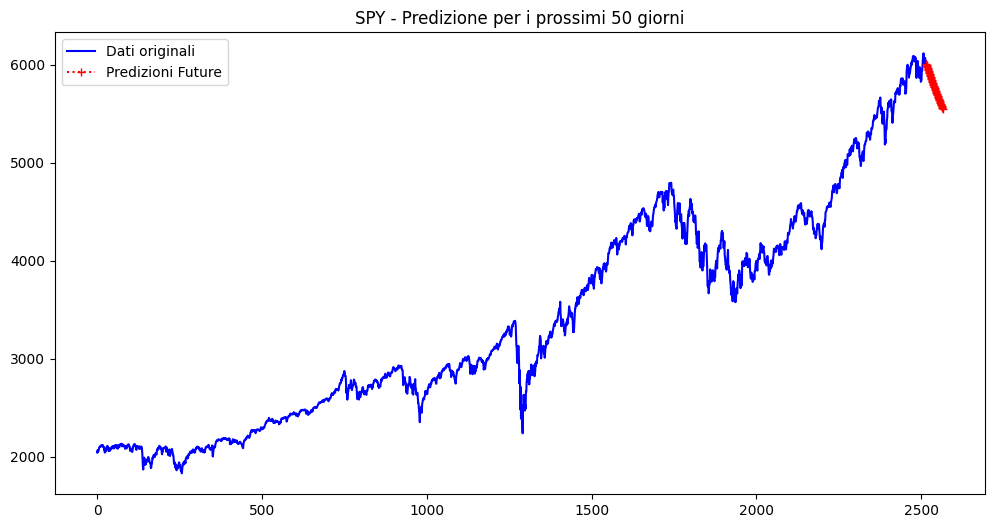

In [17]:
future_days = 50  # Numero di giorni futuri da prevedere
last_window = np.copy(x_test[-1:])  # Prende l'ultima finestra

future_predictions = []  # Lista per salvare le predizioni future

for i in range(future_days):
    next_pred = model.predict(last_window)  # Predizione per tutti i titoli
    future_predictions.append(next_pred.flatten())  # Salva i 5 valori previsti

    # Shift della finestra temporale
    last_window = np.roll(last_window, shift=-1, axis=1)
    last_window[0, -1, :] = next_pred  # Inserisce la nuova predizione all'ultimo posto

# Converti le predizioni alla scala originale
future_predictions = np.array(future_predictions)

# Creazione del grafico per ogni titolo
fig, ax = plt.subplots(figsize=(12, 6))

# Plotta i dati originali
for i, col in enumerate(data.columns):  
    ax.plot(range(len(data)), data[col], label=f"Dati originali - {col}")

# Plotta le predizioni future per ogni titolo
for i, col in enumerate(data.columns):  
    ax.plot(range(len(data), len(data) + future_days), 
            future_predictions[:, i], 'r+:', label=f"Predizione {col}")

ax.axvline(x=len(data), color='purple', linestyle='--', label="Inizio Predizione")  
ax.set_title(f"Predizione per i prossimi {future_days} giorni")
ax.legend()
plt.show()
